
# Analyse computationnelle — Playfair : Prix du blé & salaires (1565–1821)

**Source des données** : CSV public (Rdatasets) — *Wheat*  
`https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HistData/Wheat.csv`

**Objectifs**  
1. Reproduire la figure de Playfair (barres blé + surface bleue / courbe rouge salaires sur un même axe).  
2. Version modernisée avec **deux axes** (unités rigoureuses).  
3. **Pouvoir d'achat** (quarters et kg par semaine).  
4. Plan prix–salaire **sans axe du temps**, flèche temporelle.

> Conversions historiques : £1 = 20 shillings (s), 1 s = 12 pence (d).  
> 1 quarter de boisseau ≈ 6,8 kg.


In [7]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True

DATA_URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HistData/Wheat.csv"
OUT_DIR = "figures_playfair"
os.makedirs(OUT_DIR, exist_ok=True)

KG_PER_QUARTER = 6.8  # d'après l'énoncé


In [8]:

df_raw = pd.read_csv(DATA_URL)
# Colonnes attendues: rownames, Year, Wheat, Wages
df = df_raw.rename(columns={
    "Year": "annee",
    "Wheat": "ble_s_par_quarter",
    "Wages": "salaire_s_par_semaine"
})[["annee", "ble_s_par_quarter", "salaire_s_par_semaine"]].copy()

df["annee"] = pd.to_numeric(df["annee"], errors="coerce").astype("Int64")
df["ble_s_par_quarter"] = pd.to_numeric(df["ble_s_par_quarter"], errors="coerce")
df["salaire_s_par_semaine"] = pd.to_numeric(df["salaire_s_par_semaine"], errors="coerce")
df = df.sort_values("annee").reset_index(drop=True)

display(df.head())
print(df.describe(include="all"))
print("\nNA par colonne:\n", df.isna().sum())


annee  ble_s_par_quarter  salaire_s_par_semaine
0   1565               41.0                   5.00
1   1570               45.0                   5.05
2   1575               42.0                   5.08
3   1580               49.0                   5.12
4   1585               41.5                   5.15

             annee  ble_s_par_quarter  salaire_s_par_semaine
count    53.000000          53.000000              50.000000
mean   1694.924528          43.264151              11.581600
std      77.089571          15.410287               7.336287
min    1565.000000          26.000000               5.000000
25%    1630.000000          33.000000               6.145000
50%    1695.000000          41.000000               7.800000
75%    1760.000000          47.000000              14.875000
max    1821.000000          99.000000              30.000000

NA par colonne:
 annee                    0
ble_s_par_quarter        0
salaire_s_par_semaine    3
dtype: int64



## 1) Reproduction visuelle façon Playfair

- **Barres** : prix du blé *(shillings / quarter)*  
- **Surface bleue** + **courbe rouge** : salaires *(shillings / semaine)*  
> Intention historique uniquement : on partage **le même axe** malgré des unités différentes.


Figure : figures_playfair/01_playfair_reproduction.png


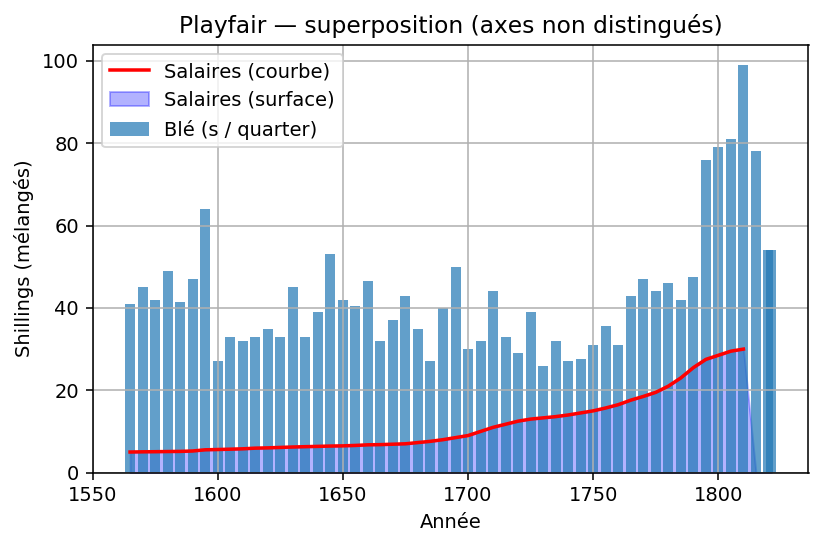

In [13]:
x = df["annee"].values
wheat = df["ble_s_par_quarter"].values
wage = df["salaire_s_par_semaine"].values

fig = plt.figure()
plt.bar(x, wheat, width=4, alpha=0.7, label="Blé (s / quarter)")
plt.fill_between(x, np.nan_to_num(wage), step=None, alpha=0.3, color="blue", label="Salaires (surface)")
plt.plot(x, wage, color="red", linewidth=1.8, label="Salaires (courbe)")

plt.title("Playfair — superposition (axes non distingués)")
plt.xlabel("Année")
plt.ylabel("Shillings (mélangés)")
plt.legend()
plt.tight_layout()

fp = os.path.join(OUT_DIR, "01_playfair_reproduction.png")
plt.savefig(fp, bbox_inches="tight")
print("Figure :", fp)
plt.show()



## 2) Présentation modernisée : axes séparés et unités correctes


Figure: figures_playfair/02_axes_separes.png


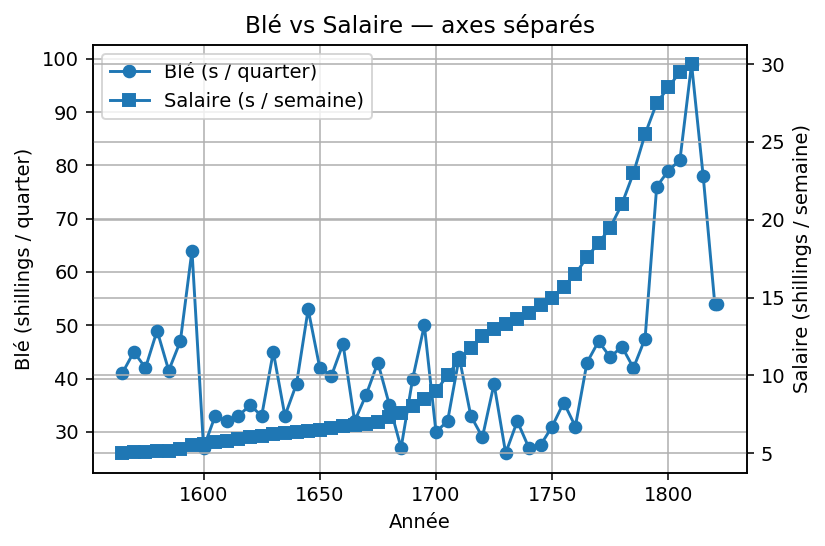

In [14]:

fig = plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()

l1 = ax1.plot(x, wheat, marker="o", linewidth=1.5, label="Blé (s / quarter)")
l2 = ax2.plot(x, wage, marker="s", linewidth=1.5, label="Salaire (s / semaine)")

ax1.set_title("Blé vs Salaire — axes séparés")
ax1.set_xlabel("Année")
ax1.set_ylabel("Blé (shillings / quarter)")
ax2.set_ylabel("Salaire (shillings / semaine)")

lines = l1 + l2
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper left")

plt.tight_layout()
fp = os.path.join(OUT_DIR, "02_axes_separes.png")
plt.savefig(fp, bbox_inches="tight")
print("Figure:", fp)
plt.show()



## 3) Pouvoir d'achat : quarters et kg par semaine


annee  quarters_achetables  kg_achetables
0   1565             0.121951       0.829268
1   1570             0.112222       0.763111
2   1575             0.120952       0.822476
3   1580             0.104490       0.710531
4   1585             0.124096       0.843855

Figure: figures_playfair/03_pouvoir_achat_quarters.png


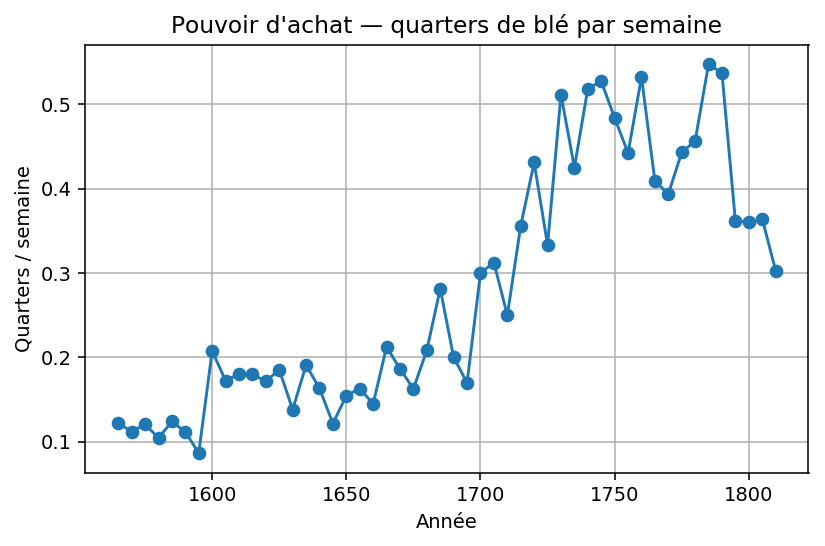

Figure: figures_playfair/03b_pouvoir_achat_kg.png


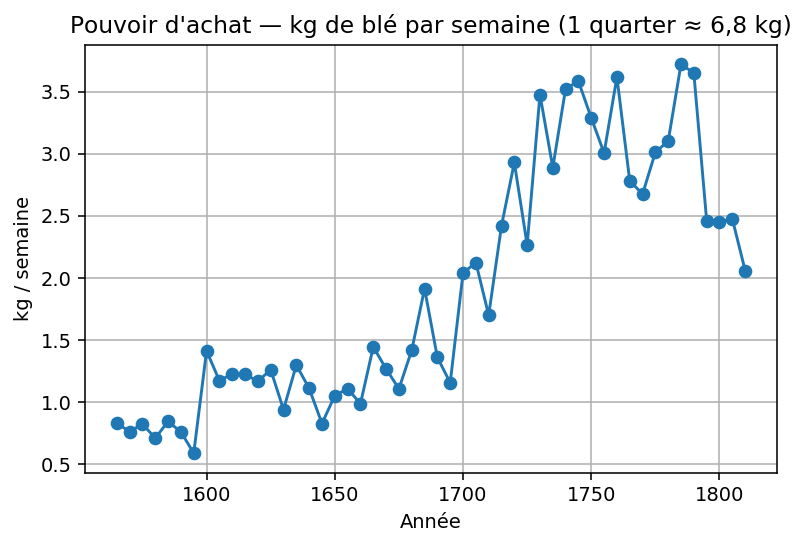

In [15]:

df_pa = df.dropna(subset=["ble_s_par_quarter", "salaire_s_par_semaine"]).copy()
df_pa["quarters_achetables"] = df_pa["salaire_s_par_semaine"] / df_pa["ble_s_par_quarter"]
df_pa["kg_achetables"] = df_pa["quarters_achetables"] * KG_PER_QUARTER

display(df_pa[["annee","quarters_achetables","kg_achetables"]].head())

fig = plt.figure()
plt.plot(df_pa["annee"], df_pa["quarters_achetables"], marker="o", linewidth=1.5)
plt.title("Pouvoir d'achat — quarters de blé par semaine")
plt.xlabel("Année")
plt.ylabel("Quarters / semaine")
plt.tight_layout()
fp = os.path.join(OUT_DIR, "03_pouvoir_achat_quarters.png")
plt.savefig(fp, bbox_inches="tight")
print("Figure:", fp)
plt.show()

fig = plt.figure()
plt.plot(df_pa["annee"], df_pa["kg_achetables"], marker="o", linewidth=1.5)
plt.title("Pouvoir d'achat — kg de blé par semaine (1 quarter ≈ 6,8 kg)")
plt.xlabel("Année")
plt.ylabel("kg / semaine")
plt.tight_layout()
fp = os.path.join(OUT_DIR, "03b_pouvoir_achat_kg.png")
plt.savefig(fp, bbox_inches="tight")
print("Figure:", fp)
plt.show()



## 4) Prix vs Salaire (sans axe du temps) avec flèche temporelle


Figure : figures_playfair/04_prix_vs_salaire_sans_temps.png


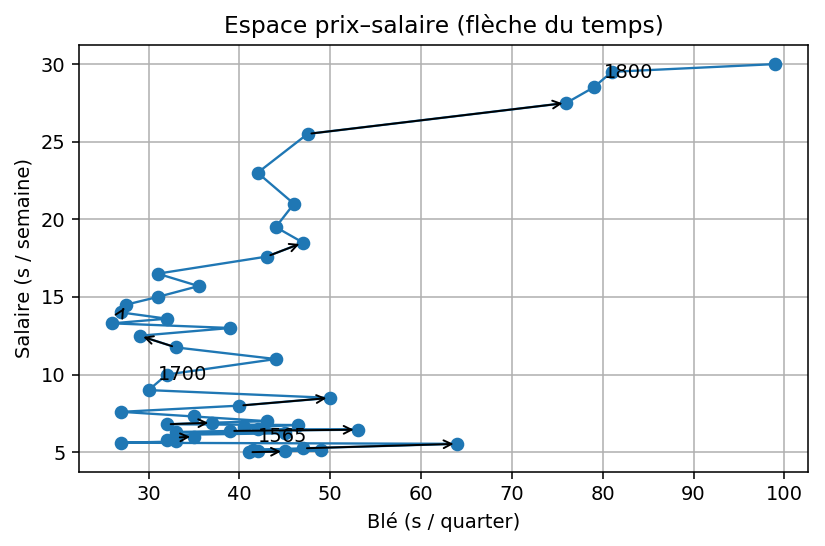

In [17]:
df_sc = df.dropna(subset=["ble_s_par_quarter", "salaire_s_par_semaine"]).copy()

fig = plt.figure()
ax = plt.gca()

ax.plot(df_sc["ble_s_par_quarter"], df_sc["salaire_s_par_semaine"], marker="o", linewidth=1.2)
ax.set_title("Espace prix–salaire (flèche du temps)")
ax.set_xlabel("Blé (s / quarter)")
ax.set_ylabel("Salaire (s / semaine)")

# Flèches directionnelles (toutes les N étapes)
N = 5
xv = df_sc["ble_s_par_quarter"].values
yv = df_sc["salaire_s_par_semaine"].values
for i in range(0, len(xv)-1, N):
    ax.annotate("", xy=(xv[i+1], yv[i+1]), xytext=(xv[i], yv[i]),
                arrowprops=dict(arrowstyle="->", lw=1))

# Annotations d'années jalons
for year in [1565, 1700, 1800, 1821]:
    row = df_sc.loc[df_sc["annee"] == year]
    if not row.empty:
        xx = float(row["ble_s_par_quarter"].values[0])
        yy = float(row["salaire_s_par_semaine"].values[0])
        ax.annotate(str(year), (xx, yy), textcoords="offset points", xytext=(5,5))

plt.tight_layout()
fp = os.path.join(OUT_DIR, "04_prix_vs_salaire_sans_temps.png")
plt.savefig(fp, bbox_inches="tight")
print("Figure :", fp)
plt.show()



### Commentaire de synthèse

- **Fig. 1** : fidélité historique, mais mélange d’unités → à cantonner à l’illustration patrimoniale.  
- **Fig. 2** : standards modernes (axes séparés), c’est la base pour un rapport sérieux.  
- **Fig. 3** : métrique décisive pour l’argument de Playfair — la clarté est maximale.  
- **Fig. 4** : complément analytique utile pour visualiser les régimes et la trajectoire conjointe prix–salaire.
